In [1256]:
# organizing all imports
import pandas as pd
import pandas as pd
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import tree
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

# __1. Decision Trees as Interpretable Models__

## __(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations__

In [1257]:
# https://www.w3schools.com/python/ref_file_readlines.asp]
# https://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.read_csv.html

path="../data/diagnosis.data"
path2="../data/diagnosis.names"
data=[]
with open(path2, 'r') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("Attribute Information"):  
            # print(lines[i])
            for j in range(i+2,i+10,1):
                line=lines[j]
                k=line.index('{')
                attri_info_data=line[3:k-1]
                data.append(attri_info_data)
print("Data is:\n {}" .format(data))

data_diagnosis=pd.read_csv(path,sep="\t+", decimal=",", encoding="UTF-16", names=data, engine='python')
for i in data_diagnosis.columns[1:]:
    data_diagnosis[i]=data_diagnosis[i].map({'yes': 1, 'no': 0})
print("\nDiagnosis data is: ")
data_diagnosis

Data is:
 ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing (continuous need for urination)', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet', 'decision: Inflammation of urinary bladder', 'decision: Nephritis of renal pelvis origin']

Diagnosis data is: 


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",decision: Inflammation of urinary bladder,decision: Nephritis of renal pelvis origin
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


### __(b) Build a decision tree on the whole data set and plot it.__

In [1258]:
# https://stackoverflow.com/questions/57854228/pandas-dataframe-index-to-list-vs-tolist
whole_data=data_diagnosis.columns[:-2].to_list()
print("Features are:\n {}" .format(whole_data))

Features are:
 ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing (continuous need for urination)', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet']


In [1259]:
# Converting multi label data into a multi class data set using label powerset method
# http://scikit.ml/api/skmultilearn.problem_transform.lp.html
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_val = data_diagnosis.iloc[:,:-2].values
target_variables=data_diagnosis.iloc[:,-2:]
new_target = LabelPowerset(classifier = DecisionTreeClassifier()).transform(target_variables)
Y_val = new_target
X_train,X_test,Y_train,Y_test = train_test_split(X_val, Y_val, test_size=0.2, random_state=0)

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/

classifier = DecisionTreeClassifier(random_state=1)
classifier.fit(X_train, Y_train)
#predict
predictions = classifier.predict(X_test)
# accuracy
accuracy_scr = accuracy_score(Y_test, predictions)
print("Accuracy score is : {}" .format(accuracy_scr))

Accuracy score is : 1.0


DECISION TREE : 


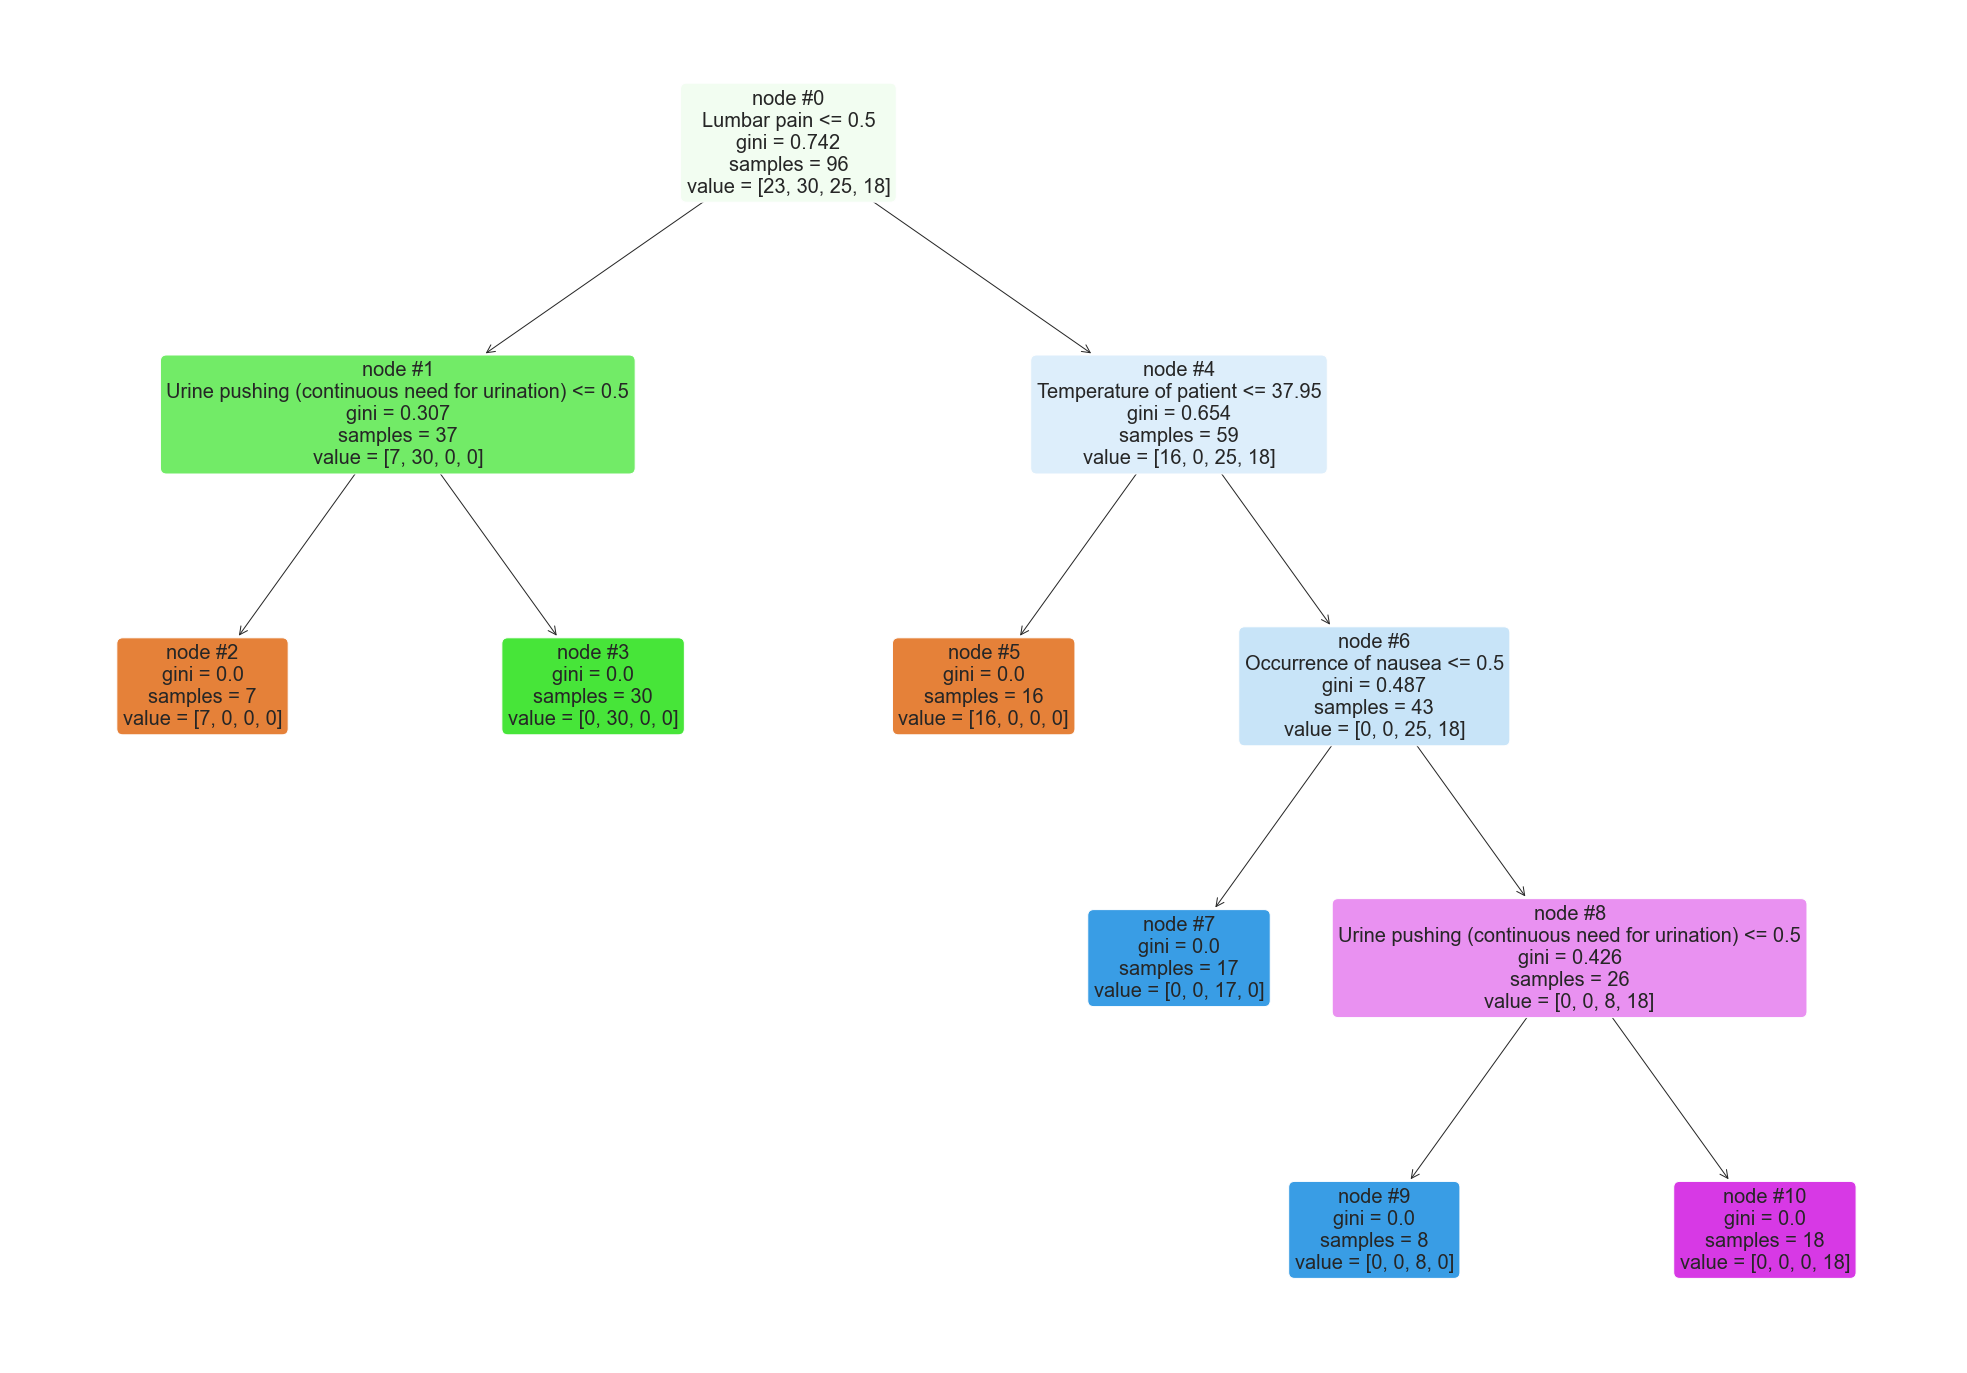

In [1260]:
# Plotting decision tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
print("DECISION TREE : ")
plt.figure(figsize=(35,25))
tree.plot_tree(classifier,feature_names=whole_data,filled=True,rounded=True,fontsize=20, node_ids = True)
plt.show()

###  __(c) Convert the decision rules into a set of IF-THEN rules__

In [1261]:
def dec_rules(tree, feature_names):
	tree_left = tree.tree_.children_left
	tree_right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	whole_data = [feature_names[i] for i in tree.tree_.feature]
	tree_value = tree.tree_.value
	def rules(tree_left, tree_right, threshold, whole_data, node, depth=0):
		indentation = "  " * depth
		if (threshold[node] != -2):
			print(indentation,"if ( " + whole_data[node] + " <= " + str(threshold[node]) + " ) {")
			if tree_left[node] != -1:
				rules (tree_left, tree_right, threshold, whole_data, tree_left[node], depth+1)
				print(indentation,"} else {")
				if tree_right[node] != -1:
					rules (tree_left, tree_right, threshold, whole_data, tree_right[node], depth+1)
				print(indentation,"}")
		else:
			print(indentation,"return " + str(tree_value[node]))
	rules(tree_left, tree_right, threshold, whole_data, 0)

In [1262]:
print("Descision rules into set of IF-THEN rules are:\n")
dec_rules(classifier, whole_data)

Descision rules into set of IF-THEN rules are:

 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing (continuous need for urination) <= 0.5 ) {
     return [[7. 0. 0. 0.]]
   } else {
     return [[ 0. 30.  0.  0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[16.  0.  0.  0.]]
   } else {
     if ( Occurrence of nausea <= 0.5 ) {
       return [[ 0.  0. 17.  0.]]
     } else {
       if ( Urine pushing (continuous need for urination) <= 0.5 ) {
         return [[0. 0. 8. 0.]]
       } else {
         return [[ 0.  0.  0. 18.]]
       }
     }
   }
 }


### __(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.__

scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.
As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

ccp_alphas : [0.         0.10901163 0.11824324 0.1838129  0.22189108]


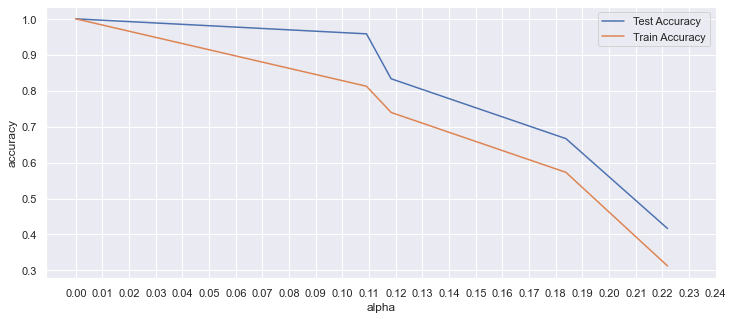

In [1263]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.

# pruning method - ccp_alpha 
path=classifier.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas=path['ccp_alphas']
print("ccp_alphas : {}" .format(ccp_alphas))

train_scores, test_scores=[],[]
for i in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=i)
    tree.fit(X_train,Y_train)
    # prediction
    Y_train_pred = tree.predict(X_train)
    Y_test_pred = tree.predict(X_test)
    # accuracy
    train_scores.append(accuracy_score(Y_train,Y_train_pred))
    test_scores.append(accuracy_score(Y_test, Y_test_pred))

# plotting the graph
sns.set()
plt.figure(figsize = (12,5))
sns.lineplot(y = test_scores,x = ccp_alphas, label = "Test Accuracy")
sns.lineplot(y = train_scores,x = ccp_alphas, label = "Train Accuracy")
plt.xticks(ticks = np.arange(0.00,0.25,0.01))
plt.ylabel('accuracy')
plt.xlabel('alpha')
plt.show()

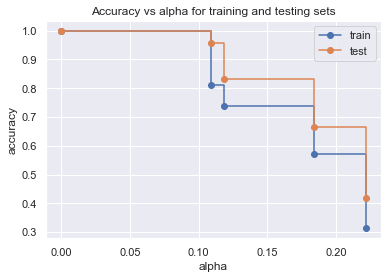

In [1264]:
# Plotting train and test accuracy
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

ccp_alphas : [0.         0.10901163 0.11824324 0.1838129  0.22189108]


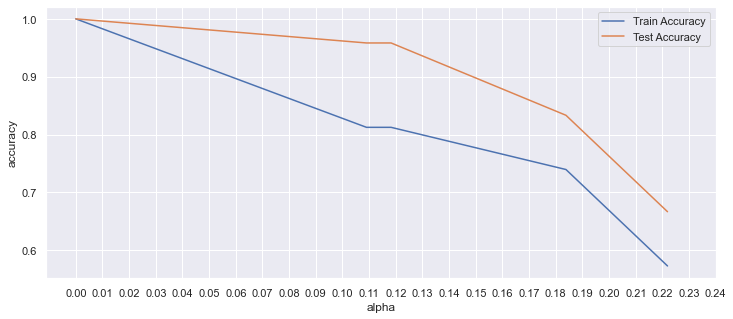

In [1265]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# pruning method - min_impurity_decrease
train_scores, test_scores=[],[]
for i in ccp_alphas:
    tree = DecisionTreeClassifier(min_impurity_decrease=i)
    tree.fit(X_train,Y_train)
    # prediction
    Y_train_pred = tree.predict(X_train)
    Y_test_pred = tree.predict(X_test)
    # accuracy
    train_scores.append(accuracy_score(Y_train,Y_train_pred))
    test_scores.append(accuracy_score(Y_test, Y_test_pred))
print("ccp_alphas : {}" .format(ccp_alphas))
# plotting the graph
sns.set()
plt.figure(figsize = (12,5))
sns.lineplot(y = train_scores,x = ccp_alphas, label = "Train Accuracy")
sns.lineplot(y = test_scores,x = ccp_alphas, label = "Test Accuracy")
plt.xticks(ticks = np.arange(0.00,0.25,0.01))
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.show()

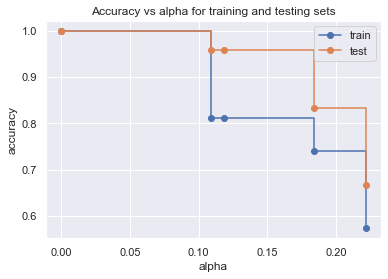

In [1266]:
# Plotting train and test accuracy
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

From the above plots, we can see for ccp_alpha=0, we get the maximum test accuracy. Our model is now more generalized and it will perform better on unseen data.

In [1267]:
classifier = DecisionTreeClassifier(random_state=1,ccp_alpha=0)
classifier.fit(X_train, Y_train)
# predict
predictions = classifier.predict(X_test)
# accuracy
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy score is : {}" .format(accuracy))
print("\nDescision rules:\n ")
dec_rules(classifier, data_diagnosis.columns[:-2].to_list())

Accuracy score is : 1.0

Descision rules:
 
 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing (continuous need for urination) <= 0.5 ) {
     return [[7. 0. 0. 0.]]
   } else {
     return [[ 0. 30.  0.  0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[16.  0.  0.  0.]]
   } else {
     if ( Occurrence of nausea <= 0.5 ) {
       return [[ 0.  0. 17.  0.]]
     } else {
       if ( Urine pushing (continuous need for urination) <= 0.5 ) {
         return [[0. 0. 8. 0.]]
       } else {
         return [[ 0.  0.  0. 18.]]
       }
     }
   }
 }


## __2. The Lasso and Boosting for Regression__

### __(a) Download the Communities and Crime data3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.__

In [1268]:
path3 = "../data/communities.data"
path4 = "../data/communities.names"

data1 = []
with open(path4, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('@attribute'):
            data1.append(line.split(' ')[1])

communities_data = pd.read_csv(path3, sep=",", header=None, names=data1, na_values='?', engine='python')
cc_train = communities_data[:1495] #first 1495 rows of data as training set
cc_test = communities_data[1495:] # rest as test set
print("The data is : ")
communities_data

The data is : 


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### __(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.__

In [1269]:
# Removing first 5 non predictive features from the data set(given in data set description)
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
# https://scikit-learn.org/stable/modules/impute.html
print("Totally", len(data1), "attributes.")
print(data1[:5], "are 5 non-predictive attributes should be removed/ignored")
non_predictive_features = ['state','county','community','communityname','fold']
predictive_features = [feature for feature in data1 if feature not in non_predictive_features]
# Doing imputation on training and testing data separately so that testing data remains true to itself, without being effected by mean of training data set.
train_data_predictive = cc_train.drop(non_predictive_features, axis=1)
# print(train_data_predictive.shape)
test_data_predictive = cc_test.drop(non_predictive_features, axis=1)

Totally 128 attributes.
['state', 'county', 'community', 'communityname', 'fold'] are 5 non-predictive attributes should be removed/ignored


In [1270]:
# columns which have Missing Values
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
print('Columns that have missing values in the train Data :\n {}' .format(train_data_predictive.columns[train_data_predictive.isnull().any()].to_list()))
print('\nColumns that have missing values in the test Data :\n {}' .format(test_data_predictive.columns[test_data_predictive.isnull().any()].to_list()))


Columns that have missing values in the train Data :
 ['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']

Columns that have missing values in the test Data :
 ['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


In [1271]:
# Using SimpleImputer for completing the missing values
# by default Mean is used for the startegy
imputer_mean = SimpleImputer(missing_values=np.nan)
imputer_mean = imputer_mean.fit(train_data_predictive)
cc_train_imp = imputer_mean.transform(train_data_predictive)
print(cc_train_imp)
train_imputed_data = pd.DataFrame(cc_train_imp, columns=predictive_features)
test_imputed_data = pd.DataFrame(imputer_mean.fit_transform(test_data_predictive), columns=predictive_features)
# Adding the column back to imputed training df
train_imputed_data

[[0.19       0.33       0.02       ... 0.32       0.14       0.2       ]
 [0.         0.16       0.12       ... 0.         0.19075314 0.67      ]
 [0.         0.42       0.49       ... 0.         0.19075314 0.43      ]
 ...
 [0.01       0.36       0.95       ... 0.         0.19075314 0.3       ]
 [0.06       0.53       0.01       ... 0.         0.19075314 0.03      ]
 [0.05       0.43       0.08       ... 0.51       0.18       0.23      ]]


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [1272]:
# Find the columns which have Missing Values
print('Columns containing Missing Values in Train Data: {}' .format(train_imputed_data.columns[train_imputed_data.isnull().any()].to_list()))
print(train_imputed_data.isnull().any().any()  )
print('Columns containing Missing Values in Test Data : {}' .format(test_imputed_data.columns[test_imputed_data.isnull().any()].to_list()))
print(test_imputed_data.isnull().any().any()  )

Columns containing Missing Values in Train Data: []
False
Columns containing Missing Values in Test Data : []
False


### __(c) Plot a correlation matrix for the features in the data set.__

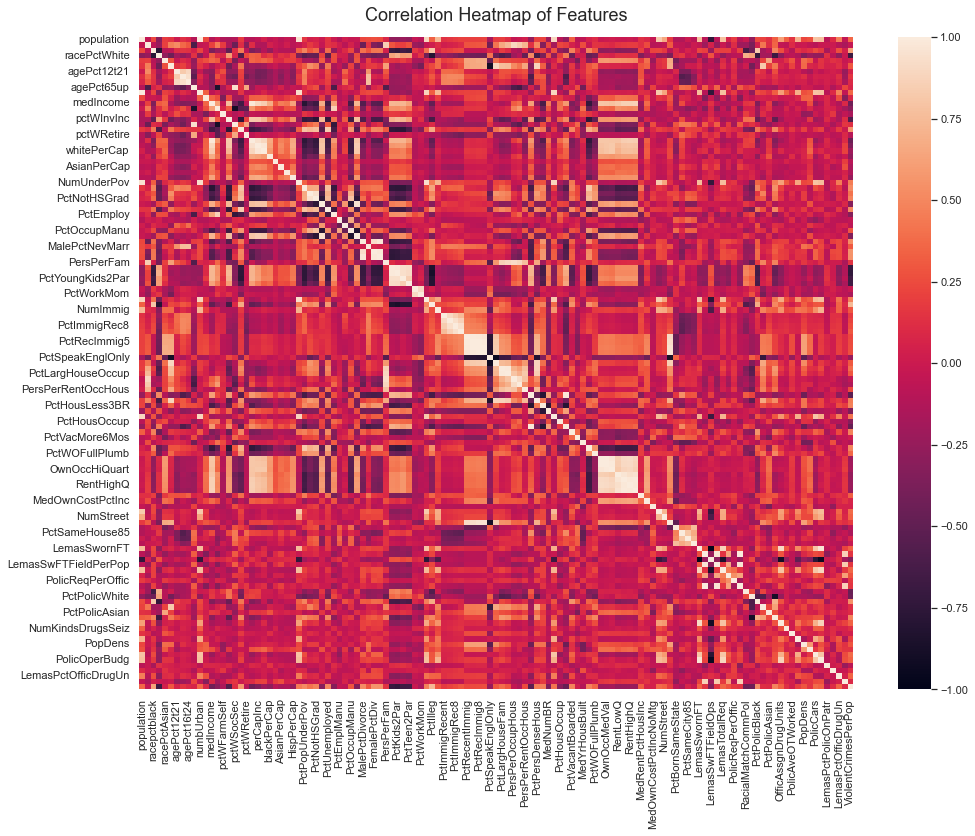

In [1273]:
# Getting correlation matrix of all the features in the whole data set
plt.close()
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(communities_data[predictive_features].corr(), vmax=1, vmin=-1)
heatmap.set_title('Correlation Heatmap of Features', fontdict={'fontsize':18}, pad=16);
plt.show()

### __(d) Calculate the Coefficient of Variation CV for each feature, where CV = $\frac{s}{m}$ , in which s is sample standard deviation and m is sample mean.__

In [1274]:
# A coefficient of variation is a way to measure how spread out values are in a dataset relative to the mean.
# define function to calculate cv
cv = communities_data[predictive_features].apply(lambda column : column.std() / column.mean(), axis=0)
print("A coefficient of variation is a way to measure how spread out values are in a dataset relative to the mean.\n\nCV for each feature is : \n{}" .format(cv))

A coefficient of variation is a way to measure how spread out values are in a dataset relative to the mean.

CV for each feature is : 
population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.306251
LemasGangUnitDeploy    0.921372
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.844368
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64


In [1275]:
print(cv.sort_values(ascending=False))
# print(type(cv.sort_values(ascending=False)))

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
                         ...   
PctSameState85         0.304240
agePct12t29            0.290693
PctSpeakEnglOnly       0.288673
PctHousOccup           0.269647
LemasSwFTFieldOps      0.143013
Length: 123, dtype: float64


### __(e) Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?__

In [1276]:
no_of_features = int(np.floor(np.sqrt(128)))
print("The number of features: {}\n".format(no_of_features))
# Select features with high CV
highCVFeatures = cv.sort_values(ascending=False)[:no_of_features]

print("The 11 features with best cv are:")
print(highCVFeatures)
# print(type(highCVFeatures))

# changing type to list and printing
best_feat = highCVFeatures.index.to_list()
highCVFeatures.values
print("\n Best features:\n{}".format(best_feat))
print("\n{}".format(highCVFeatures))


The number of features: 11

The 11 features with best cv are:
NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
HousVacant             1.958780
dtype: float64

 Best features:
['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'LemasSwornFT', 'PctPolicAsian', 'HousVacant']

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
HousVacant             1.958780
dtype: float64


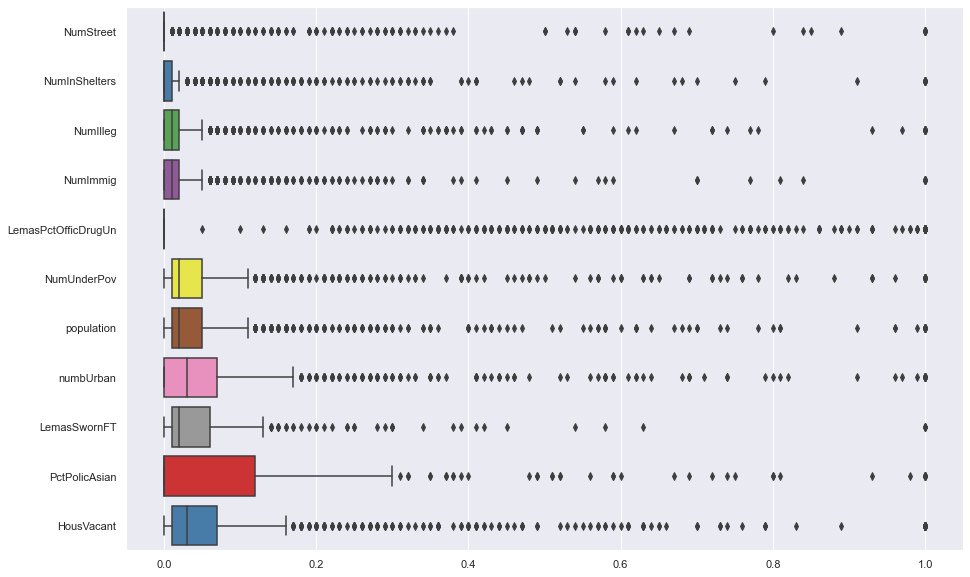

In [1277]:
plt.close()
plt.figure(figsize=(15,10))
sns.boxplot(data=communities_data[best_feat], orient="h", palette="Set1")
plt.show()

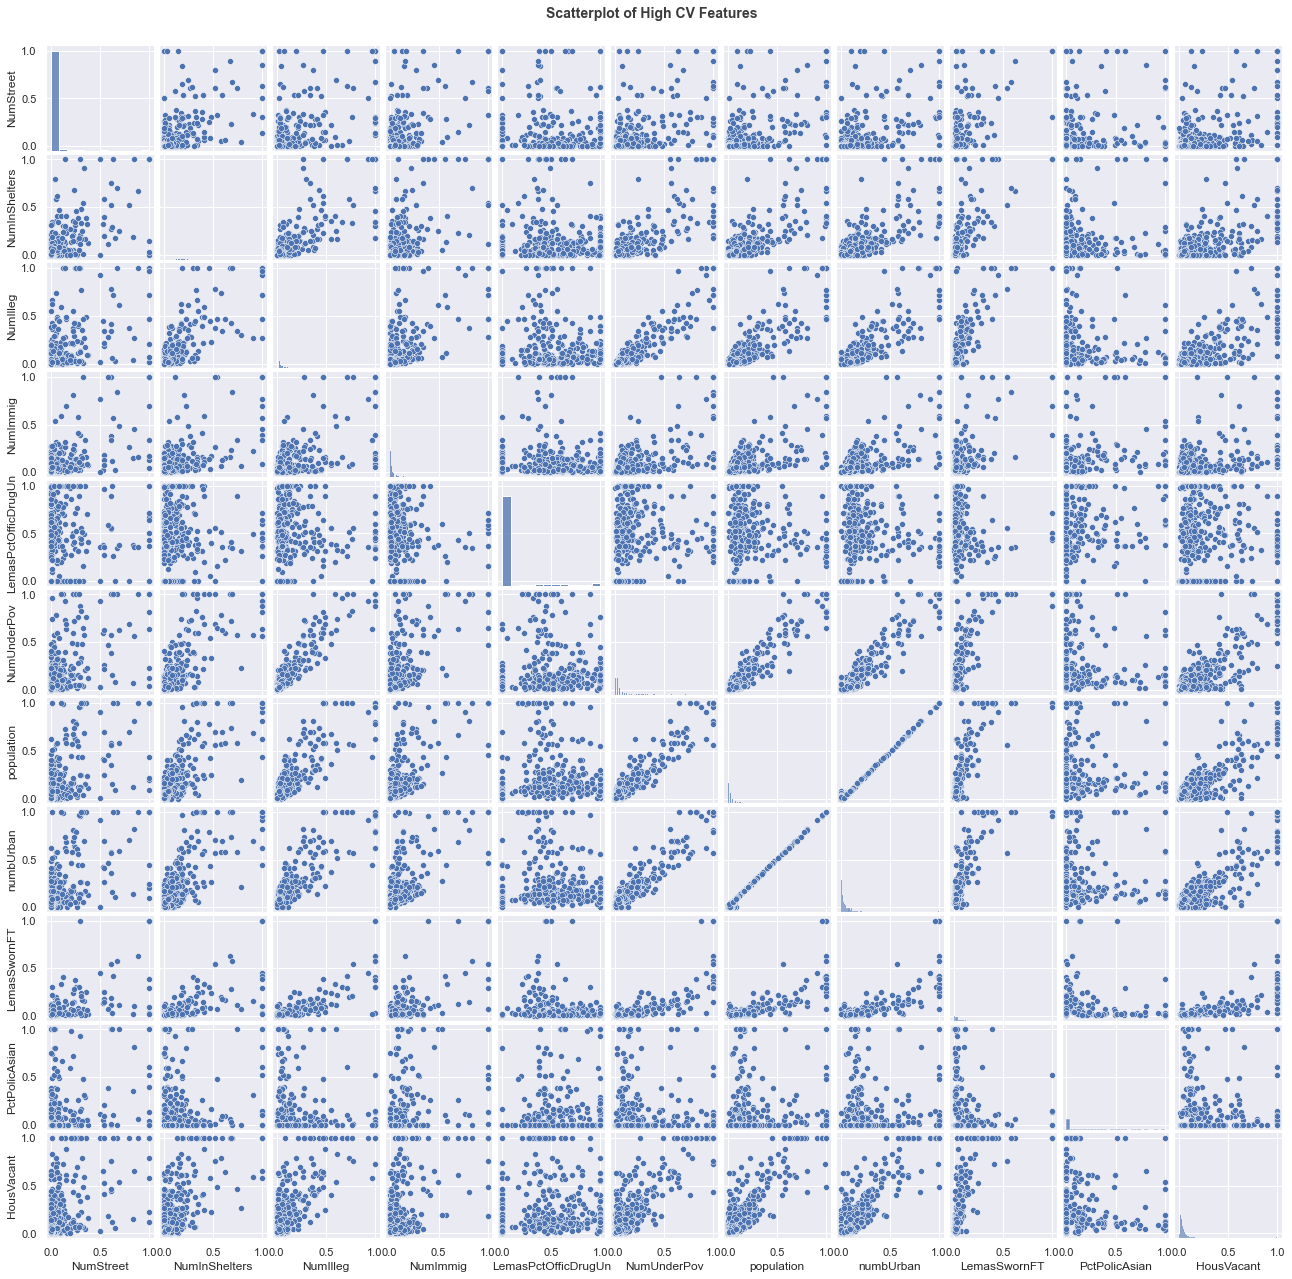

In [1278]:
plt.close()
s_figure = sns.pairplot(communities_data[best_feat], kind='scatter');
s_figure.fig.set_size_inches(18,18)

s_figure.fig.subplots_adjust(top=0.95)
s_figure.fig.suptitle('Scatterplot of High CV Features', fontsize = 14, alpha = 0.9, weight = 'bold')
plt.show()

#### __Can you draw conclusions about significance of those features, just by the scatter plots?__

The data points in most of the cases are spread across it's hard to make conclusions about significance of those features just by the scatter plots and thus difficult to find out a pattern. But following features have correlation between themselves: 
 - Numlleg with NumUnderPov,population and numbUrban 
 - NumUnderPov with population and numburban 
 - population with numbUrban shows strong clear linear relation 
 - Housevacant has weak corelation with NumUnderPov,population and numbUrban

### __(f) Fit a linear model using least squares to the training set and report the test error.__

In [1279]:
# All algorithms test MSE
all_test_mse = pd.DataFrame(columns=['algorithm', 'MSE'])

In [1280]:
train_X = train_imputed_data.iloc[:, :-1]
train_Y = train_imputed_data.iloc[:, -1]

test_X = test_imputed_data.iloc[:, :-1]
test_Y = test_imputed_data.iloc[:, -1]

In [1281]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  
# model_fit = LinearRegression().fit(train_X, train_Y)
# pred = model_fit.predict(test_X)
# mod_mse = mean_squared_error(test_Y, pred)

# # Storing Algorithm MSE
# test_data = pd.Series(['Linear Regression', mod_mse], index = ['algorithm', 'MSE'])
# all_test_mse = all_test_mse.append(test_data, ignore_index=True)
# print(test_data)
# rSquare = model_fit.score(test_X,test_Y)
# print('R-Square: {}' .format(rSquare))

In [1282]:
# Using OLS to find significance 
train_x = sm.add_constant(train_X)
test_x = sm.add_constant(test_X)
model = sm.OLS(train_Y, train_x).fit()
predict = model.predict(test_x)
mse_score = mean_squared_error(test_Y, predict)
# R2 score for testing data
r_square = r2_score(test_Y, predict)
# Storing Algorithm MSE
test_data = pd.Series(['OLS', mse_score], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
print("Test Error of OLS:{:.4F}".format(mse_score))
print('R-square {}' .format(r_square))

Test Error of OLS:0.0181
R-square 0.6191284293191184


In [1283]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.711
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.94
Date:                 Fri, 28 Oct 2022   Prob (F-statistic):          6.56e-291
Time:                         14:14:30   Log-Likelihood:                 955.40
No. Observations:                 1495   AIC:                            -1667.
Df Residuals:                     1373   BIC:                            -1019.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4544      0.904      0.503      0.615      -1.319       2.228
population               -0.0199      0.477     -0.042      0.967      -0.955       0.916
householdsize            -0.0157      0.098     -0.161      0.872      -0.207       0.176
racepctblack              0.2848      0.060      4.754      0.000       0.167       0.402
racePctWhite              0.0106      0.067      0.159      0.874      -0.120       0.141
racePctAsian             -0.0278      0.041     -0.670      0.503      -0.109       0.054
racePctHisp               0.0180      0.065      0.275      0.784      -0.110       0.146
agePct12t21               0.1792      0.129      1.387      0.166      -0.074       0.433
agePct12t29              -0.3451      0.186     -1.858      0.063      -0.709       0.019
agePct16t24              -0.1237      0.198     -0.626      0.531      -0.511       0.264
agePct65up                0.0597      0.124      0.481      0.630      -0.184       0.303
numbUrban                -0.1260      0.465     -0.271      0.786      -1.038       0.786
pctUrban                  0.0484      0.019      2.581      0.010       0.012       0.085
medIncome                -0.1784      0.202     -0.881      0.378      -0.575       0.219
pctWWage                 -0.1399      0.107     -1.309      0.191      -0.350       0.070
pctWFarmSelf              0.0460      0.023      1.960      0.050   -3.35e-05       0.092
pctWInvInc               -0.2031      0.081     -2.505      0.012      -0.362      -0.044
pctWSocSec                0.1368      0.125      1.092      0.275      -0.109       0.383
pctWPubAsst               0.0601      0.054      1.109      0.268      -0.046       0.166
pctWRetire               -0.1249      0.045     -2.802      0.005      -0.212      -0.037
medFamInc                 0.3049      0.189      1.617      0.106      -0.065       0.675
perCapInc                -0.0485      0.222     -0.219      0.827      -0.484       0.387
whitePerCap              -0.1923      0.179     -1.072      0.284      -0.544       0.160
blackPerCap              -0.0401      0.030     -1.358      0.175      -0.098       0.018
indianPerCap             -0.0436      0.023     -1.911      0.056      -0.088       0.001
AsianPerCap               0.0301      0.022      1.381      0.168      -0.013       0.073
OtherPerCap               0.0304      0.022      1.364      0.173      -0.013       0.074
HispPerCap                0.0330      0.029      1.150      0.250      -0.023       0.089
NumUnderPov               0.0737      0.192      0.383      0.702      -0.303       0.451
PctPopUnderPov           -0.2035      0.074     -2.736      0.006      -0.349      -0.058
PctLess9thGrade          -0.0584      0.079     -0.743      0.457      -0.213       0.096
PctNotHSGrad

### __(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.__

In [1284]:

# k-fold cv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
# https://scikit-learn.org/stable/modules/model_evaluation.html
k_fold_cv = KFold(5, shuffle=True, random_state=7)
# taking alpha as suggested on piazza
alphas = [10 ** i for i in range(-4, 4)]
# Ridge Model
ridgeModel = RidgeCV(alphas=alphas, cv=k_fold_cv).fit(train_X, train_Y)
pred = ridgeModel.predict(test_X)
rSquare = ridgeModel.score(test_X,test_Y)
mod_mse = mean_squared_error(test_Y, pred)
test_data = pd.Series(['Ridge Regression', mod_mse], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
print('Best alpha by Ridge CV : ', (ridgeModel.alpha_))
print('Test Error using Ridge : ', mod_mse)
print('R2 score for testing data:', rSquare)

Best alpha by Ridge CV :  1.0
Test Error using Ridge :  0.01772373712282779
R2 score for testing data: 0.6273025949527168


- __R2 score for ridge regression model is improved as compared to R2 score of linear regression model__

### __(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.__

__Lasso for Raw data__

In [1285]:
# Lasso Regression Model 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
alphas = [10 ** i for i in range(-4, 4)]
lassoModel = LassoCV(alphas=alphas, cv=k_fold_cv, random_state = 0).fit(train_X, train_Y)
pred = lassoModel.predict(test_X)
rSquare = lassoModel.score(test_X,test_Y)
mod_mse = mean_squared_error(test_Y, pred)
test_data = pd.Series(['LASSO', mod_mse], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
# Selected variables using lasso regression 
print('Best alpha by Lasso CV : ', (lassoModel.alpha_))
print('R-Square:', rSquare)
print('Test Error using Lasso  : ', mod_mse)

Best alpha by Lasso CV :  0.0001
R-Square: 0.6264040950583222
Test Error using Lasso  :  0.017766465555377833


In [1286]:
# Selected features using lasso regression fit
lasso_selected_features = pd.Series(data=lassoModel.coef_[lassoModel.coef_!=0],
                                  index=test_X.columns[lassoModel.coef_!=0])

lasso_selected_features

racepctblack           0.273052
racePctAsian          -0.017982
agePct12t21            0.076001
agePct12t29           -0.291125
agePct65up             0.003873
                         ...   
PctUsePubTrans        -0.047532
PolicCars              0.000543
LemasPctPolicOnPatr    0.021727
LemasGangUnitDeploy    0.040690
LemasPctOfficDrugUn    0.000618
Length: 78, dtype: float64

### __Lasso Model with Standardized data__

__Using Normalized data for lasso regression__

In [1287]:
# Standardize the training set
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
alphas = [10 ** i for i in range(-4, 4)]
scaler = StandardScaler()
standard_train_X = scaler.fit_transform(train_X)
standard_test_X = scaler.fit_transform(test_X)
standard_train_X = pd.DataFrame(data=standard_train_X, columns=train_X.columns)
standard_test_X = pd.DataFrame(data=standard_test_X, columns=test_X.columns)
# Refit a Lasso model using standardized values
lassoModel = LassoCV(alphas=alphas, cv=k_fold_cv).fit(standard_train_X, train_Y)
pred = lassoModel.predict(standard_test_X)
rSquare = lassoModel.score(standard_test_X,test_Y)
mod_mse = mean_squared_error(test_Y, pred)

# Storing Algorithm MSE
test_data = pd.Series(['Standardized LASSO', mod_mse], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
print('Alpha Selected by Lasso CV with Standardized features : ', (lassoModel.alpha_))
print('R-Square:', rSquare)
print('Test Error using Lasso: ', mod_mse)

Alpha Selected by Lasso CV with Standardized features :  0.001
R-Square: 0.6224384692004039
Test Error using Lasso:  0.017955052085043402


In [1288]:
# selected features using lasso regression fit
lasso_selected_features_standard = pd.Series(data=lassoModel.coef_[lassoModel.coef_!=0], 
                                             index=standard_test_X.columns[lassoModel.coef_!=0])
lasso_selected_features_standard

racepctblack           0.066805
agePct12t21            0.005265
agePct12t29           -0.028572
pctUrban               0.015660
pctWWage              -0.008793
                         ...   
PopDens                0.002540
PctUsePubTrans        -0.007038
PolicCars              0.002432
LemasPctPolicOnPatr    0.002066
LemasGangUnitDeploy    0.006239
Length: 68, dtype: float64

#### Observations: 
- Test MSE's are almost same ()for Lasso with Standardizing the predictors and Without.
- Using Standardized features, dimensionality of Lasso Regression decreases and it's easy to compare any features.

### __(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.__

In [1289]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


def find_PCRCV(train_X, train_Y, fold, dimension):
    k_fold_cv = KFold(fold, shuffle=True, random_state=7)
    cv_error = 0
    for train_idx, validation_idx in k_fold_cv.split(train_X):
        train_CV_X, validation_CV_X = train_X.iloc[train_idx, :], train_X.iloc[validation_idx, :]
        train_CV_Y, validation_CV_Y = train_Y.iloc[train_idx], train_Y.iloc[validation_idx]
        pca = PCA(n_components = dimension).fit(train_CV_X)
        train_pca = pca.transform(train_CV_X)
        valid_pca = pca.transform(validation_CV_X)
        model_fit = LinearRegression().fit(train_pca, train_CV_Y)
        valid_pred = model_fit.predict(valid_pca)
        valid_mse = mean_squared_error(validation_CV_Y, valid_pred)
        cv_error += valid_mse
    return cv_error / fold
result_df = pd.DataFrame(columns=['components', 'MSE'])
for i in tqdm(range(1, len(train_X.columns) + 1)):
    lst = []
    valid_err = find_PCRCV(train_X, train_Y, 5, i)
    lst.extend([i, valid_err])
    lst_data = pd.Series(lst, index = ['components', 'MSE'])
    result_df = result_df.append(lst_data, ignore_index=True)
result_df['components'] = result_df['components'].astype(int)
result_df

100%|██████████| 122/122 [00:57<00:00,  2.11it/s]


,components,MSE
0,1,0.038199
1,2,0.030798
2,3,0.027758
3,4,0.024297
4,5,0.023149
...,...,...
117,118,0.020200
118,119,0.020249
119,120,0.020285
120,121,0.020372


RuntimeError: matplotlib does not support generators as input

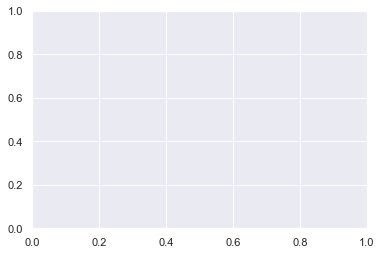

In [1296]:
plt.plot(k_fold_cv.split(train_X), result_df)

In [1290]:
# Getting index of best cv error
best_component = (result_df[result_df['MSE'] == result_df['MSE'].min()]).values.tolist()[0]
best_component
print('From using cross-validation to find the M value that gives the lowest PCR score \nMinimum Validation MSE is {} When M (the number of principle components) = {}'.format(best_component[1], int(best_component[0])))

pca = PCA(n_components = int(best_component[0])).fit(train_X)
train_pca = pca.transform(train_X)
pca_test = pca.transform(test_X)
model_fit = LinearRegression()
model_fit.fit(train_pca, train_Y)
test_pred = model_fit.predict(pca_test)
mod_mse = mean_squared_error(test_Y, test_pred)
test_data = pd.Series(['PCA', mod_mse], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
print('Best Test Error using PCA : ', mod_mse)

From using cross-validation to find the M value that gives the lowest PCR score 
Minimum Validation MSE is 0.019417879564837516 When M (the number of principle components) = 96
Best Test Error using PCA :  0.01844475190746086


### __(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine $\alpha$ (the regularization term) using cross-validation.__

In [1291]:
# https://xgboost.readthedocs.io/en/latest/get_started.html
# https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix
# https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv#xgboost.cv
# https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
cv_result_xgboost = pd.DataFrame(columns=['alpha', 'CV_Score'])
alphas = [10 ** i for i in range(-5, 5)]
k_fold_cv = KFold(5, shuffle=True, random_state=7)
for alpha in tqdm(alphas):
    lst = []
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", reg_alpha=alpha)
    cv_scores = cross_val_score(xgb_model, train_X, train_Y, cv=k_fold_cv, scoring="neg_mean_squared_error")
    lst.extend([alpha, np.abs(cv_scores.mean())])
    lst_data = pd.Series(lst, index = ['alpha', 'CV_Score'])
    cv_result_xgboost = cv_result_xgboost.append(lst_data, ignore_index=True)
cv_result_xgboost

100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


,alpha,CV_Score
0,0.00001,0.023158
1,0.00010,0.023462
2,0.00100,0.022987
3,0.01000,0.023007
4,0.10000,0.022259
5,1.00000,0.020862
6,10.00000,0.022029
7,100.00000,0.037532
8,1000.00000,0.123747
9,10000.00000,0.123747


In [1292]:
best_a = (cv_result_xgboost[cv_result_xgboost['CV_Score'] 
                                == cv_result_xgboost['CV_Score'].min()]).values.tolist()[0]
best_a
print('Minimum Validation MSE is {} and its best alpha is = {}'.format(best_a[1], float(best_a[0])))
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha= float(best_a[0]))
xgb_model.fit(train_X, train_Y)
test_pred = xgb_model.predict(test_X)
mod_mse = mean_squared_error(test_Y, test_pred)
test_data = pd.Series(['XGBoost', mod_mse], index = ['algorithm', 'MSE'])
all_test_mse = all_test_mse.append(test_data, ignore_index=True)
print('Test Error using XGBoost : ', mod_mse)

Minimum Validation MSE is 0.020862288663380923 and its best alpha is = 1.0
Test Error using XGBoost :  0.017432515156236016


### __Summary__

In [1293]:
all_test_mse

,algorithm,MSE
0,OLS,0.018112
1,Ridge Regression,0.017724
2,LASSO,0.017766
3,Standardized LASSO,0.017955
4,PCA,0.018445
5,XGBoost,0.017433


In [1294]:
best_algo = (all_test_mse[all_test_mse['MSE'] == all_test_mse['MSE'].min()]).values.tolist()[0]
best_algo

print('Among all the models Minimum Validation MSE is {} for Algorithm = {}'.format(best_algo[1], best_algo[0]))

Among all the models Minimum Validation MSE is 0.017432515156236016 for Algorithm = XGBoost


__References and citations:__

1. https://www.w3schools.com/python/ref_file_readlines.asp]
2. https://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.read_csv.html
3. https://stackoverflow.com/questions/57854228/pandas-dataframe-index-to-list-vs-tolist
4. http://scikit.ml/api/skmultilearn.problem_transform.lp.html
5. https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
6. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
8. https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/
9. https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
10. https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.
11. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
12. https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
13. https://scikit-learn.org/stable/modules/impute.html
14. https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
15. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
16. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
17. https://xgboost.readthedocs.io/en/latest/get_started.html
18. https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix
19. https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv#xgboost.cv
20. https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
21. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
22. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
23. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
24. https://scikit-learn.org/stable/modules/model_evaluation.html
25. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html